In [1]:
import os
import glob
import pickle
from collections import deque

import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

LARGE_FIGSIZE = (10, 5)

# Project env parameters
CAL_PATH = './camera_cal'
CAM_IMG_SIZE = (1280, 720)
OUTPUT_IMGS_PATH = './output_images'
TEST_IMGS_PATH = './test_images'
PROJECT_VIDEO_PATH = './project_video.mp4'

# Camera Calibration

In [2]:
# Get list of calibration images
calibration_imgs = []
for img_f in glob.glob(os.path.join(CAL_PATH, "calibration*.jpg")):
    img = mpimg.imread(img_f)
    img = cv2.resize(img, CAM_IMG_SIZE)
    calibration_imgs.append(img)

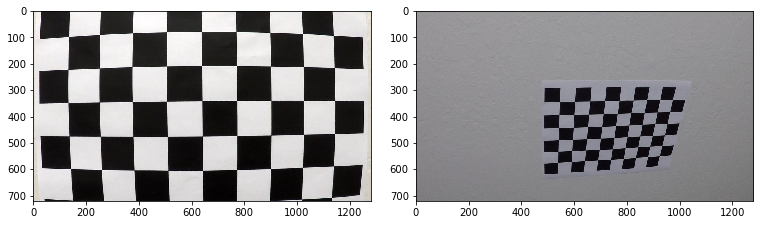

In [3]:
# Show distorted image examples
f, (ax1, ax2) = plt.subplots(1, 2, figsize=LARGE_FIGSIZE)
f.tight_layout()
ax1.imshow(calibration_imgs[0])
ax2.imshow(calibration_imgs[1])
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

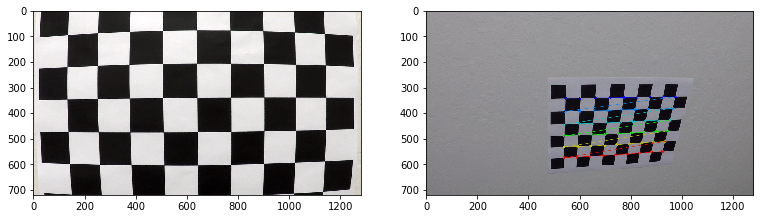

In [4]:
# Number of corners
corner_nx = 9
corner_ny = 6

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((corner_ny*corner_nx,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_nx, 0:corner_ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for img in calibration_imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (corner_nx, corner_ny), None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (corner_nx, corner_ny), corners, ret)
        
# Show example corners
f, (ax1, ax2) = plt.subplots(1, 2, figsize=LARGE_FIGSIZE)
ax1.imshow(calibration_imgs[0])
ax2.imshow(calibration_imgs[1])
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

It is always good to have multiple calibration images, as some of them may not have clear corners to be used for calibration shown as left image on above.

In [5]:
# Calculate distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                   imgpoints, 
                                                   CAM_IMG_SIZE, 
                                                   None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open(os.path.join(CAL_PATH, "dist_pickle.p"), "wb"))

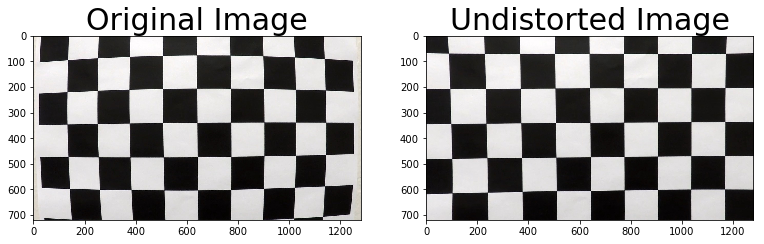

In [6]:
# Show undistorted image example
img = calibration_imgs[0]
undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(os.path.join(OUTPUT_IMGS_PATH, "undistorted_image_example.jpg"), undist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=LARGE_FIGSIZE)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Advanced Lane Finding Pipeline

In [7]:
# Load test image with lane lines
test_imgs = []
for img_f in glob.glob(os.path.join(TEST_IMGS_PATH, 'test*.jpg')):
    img = mpimg.imread(img_f)
    img = cv2.resize(img, CAM_IMG_SIZE)
    test_imgs.append(img)

## Distortion-correction

In [8]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load(open(os.path.join(CAL_PATH, "dist_pickle.p"), "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

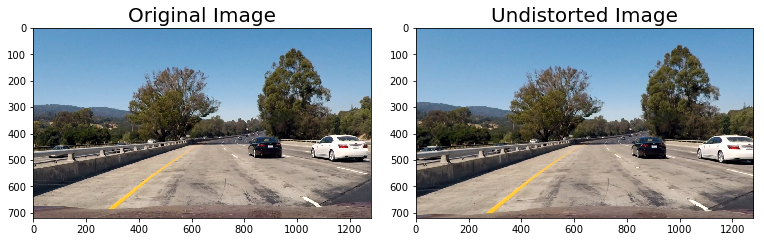

In [9]:
# Show undistorted image example
example_img = test_imgs[0]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=LARGE_FIGSIZE)
f.tight_layout()
ax1.imshow(example_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistort(example_img))
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig(os.path.join(OUTPUT_IMGS_PATH, 'distortion-correction.png'), transparent=True)

In [10]:
for i in range(len(test_imgs)):
    test_imgs[i] = undistort(test_imgs[i])
example_img = test_imgs[0]
example_img_gray = cv2.cvtColor(example_img, cv2.COLOR_RGB2GRAY)
example_img_hls = cv2.cvtColor(example_img, cv2.COLOR_RGB2HLS)

## Gradient Thresholding

In [11]:
def abs_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    This function applies Sobel x or y and creates a thresholded binary image
    based on the absolute value of the gradient.
    """
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    """
    This function applies Sobel x or y and creates a thresholded binary image
    based on the magnitude of the gradient.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_thresh(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    This function applies Sobel x or y and creates a thresholded binary image
    based on the direction of the gradient.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

## Color Thresholding

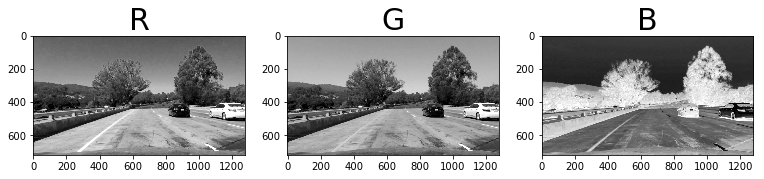

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=LARGE_FIGSIZE)
ax1.set_title('R', fontsize=30)
ax1.imshow(example_img[:,:,0], cmap='gray')
ax2.set_title('G', fontsize=30)
ax2.imshow(example_img[:,:,1], cmap='gray')
ax3.set_title('B', fontsize=30)
ax3.imshow(example_img[:,:,2], cmap='gray_r')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

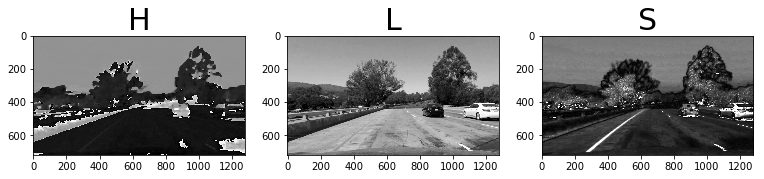

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=LARGE_FIGSIZE)
ax1.set_title('H', fontsize=30)
ax1.imshow(example_img_hls[:,:,0], cmap='gray')
ax2.set_title('L', fontsize=30)
ax2.imshow(example_img_hls[:,:,1], cmap='gray')
ax3.set_title('S', fontsize=30)
ax3.imshow(example_img_hls[:,:,2], cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

As shown in above figures, R channel and S channel provide much clearer extraction of lane lines. So for color thresholding, I will use R channel and S channel as default and only them in this project.

In [14]:
def rgb_thresh(rgb, channel='r', thresh=(0, 255)):
    """
    This function creates a thresholded binary image
    based on the provided channel.
    """
    channel = rgb[:,:,'rgb'.index(channel)]
    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary
    
def hls_thresh(hls, channel='s', thresh=(0, 255)):
    """
    This function covert img into HLS and creates a thresholded binary image
    based on the provided channel.
    """
    channel = hls[:,:,'hls'.index(channel)]
    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary

## Show different types of thresholded binary image examples

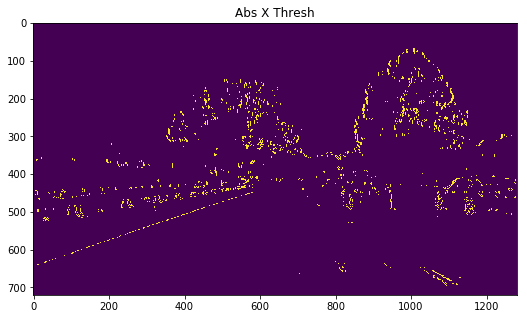

In [15]:
# Show different types of thresholded binary image example
abs_x_binary = abs_thresh(example_img_gray, sobel_kernel=11, thresh=(50, 100))
plt.figure(figsize=LARGE_FIGSIZE)
plt.title('Abs X Thresh')
plt.imshow(abs_x_binary)

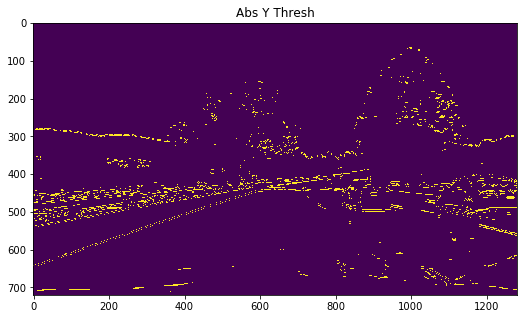

In [16]:
abs_y_binary = abs_thresh(example_img_gray, sobel_kernel=11, orient='y', thresh=(50, 80))
plt.figure(figsize=LARGE_FIGSIZE)
plt.title('Abs Y Thresh')
plt.imshow(abs_y_binary)

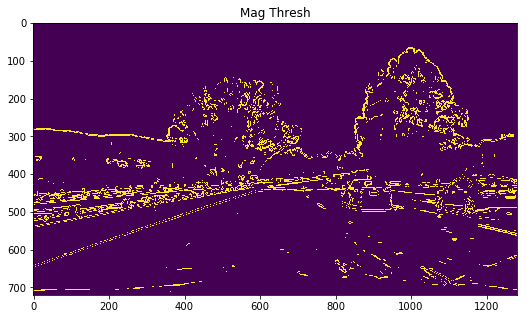

In [17]:
mag_binary = mag_thresh(example_img_gray, sobel_kernel=11, thresh=(45, 90))
plt.figure(figsize=LARGE_FIGSIZE)
plt.title('Mag Thresh')
plt.imshow(mag_binary)

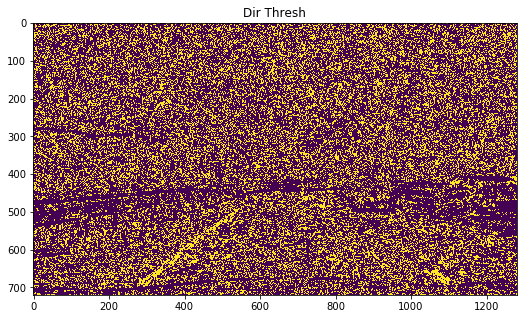

In [18]:
dir_binary = dir_thresh(example_img_gray, sobel_kernel=11, thresh=(0.7, 1.2))
plt.figure(figsize=LARGE_FIGSIZE)
plt.title('Dir Thresh')
plt.imshow(dir_binary)

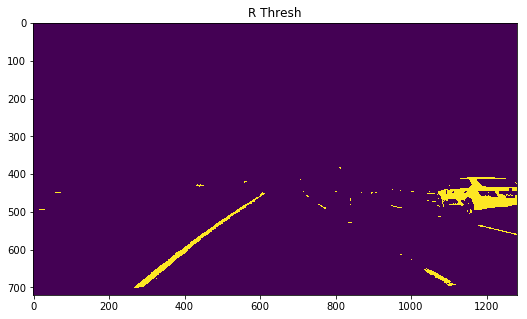

In [19]:
r_binary = rgb_thresh(example_img, thresh=(225, 255))
plt.figure(figsize=LARGE_FIGSIZE)
plt.title('R Thresh')
plt.imshow(r_binary)

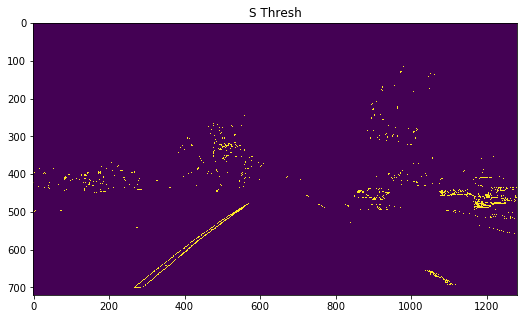

In [20]:
s_binary = hls_thresh(example_img_hls, thresh=(170, 240))
plt.figure(figsize=LARGE_FIGSIZE)
plt.title('S Thresh')
plt.imshow(s_binary)

## Combined Thresholding

In [21]:
def combined_thresh(img):
    """
    This function creates a thresholded binary image
    based on combination of different types of thresholding.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    abs_x_binary = abs_thresh(gray, sobel_kernel=11, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=11, thresh=(45, 90))
    dir_binary = dir_thresh(gray, sobel_kernel=11, thresh=(0.7, 1.2))
    r_binary = rgb_thresh(img, thresh=(225, 255))
    s_binary = hls_thresh(hls, thresh=(170, 240))
    
    # line extract threshold
    line_thresh = (r_binary == 1)
    # enhance threshold
    enhance_thresh = (((s_binary == 1) | (abs_x_binary == 1) | (mag_binary == 1)) & (dir_binary == 1))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[line_thresh | enhance_thresh] = 1
    return combined_binary

def apply_combined_thresh(img):
    """
    This function applys combined thresholding mask to the undistorted image.
    """
    img = undistort(img)
    combined_binary = combined_thresh(img)
    return cv2.bitwise_and(img, img, mask=combined_binary)

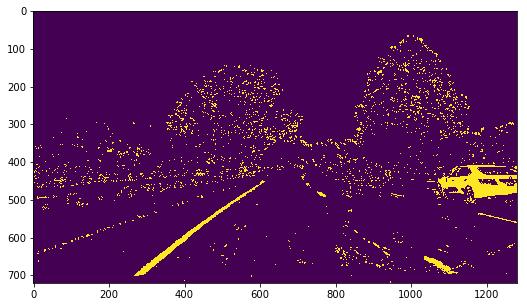

In [22]:
combined_binary = combined_thresh(example_img)
cv2.imwrite(os.path.join(OUTPUT_IMGS_PATH, "threshed_binary.jpg"), 
            np.dstack((combined_binary,combined_binary,combined_binary))*255)
plt.figure(figsize=LARGE_FIGSIZE)
plt.imshow(combined_binary)

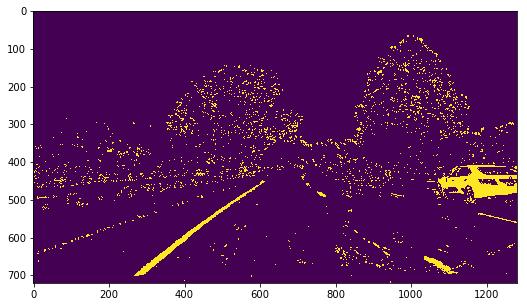

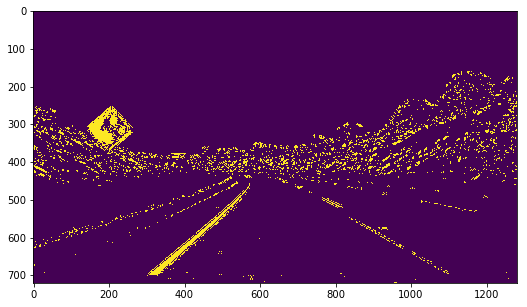

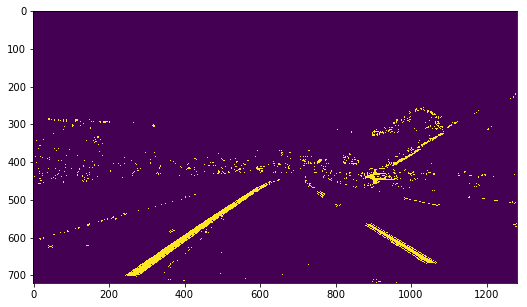

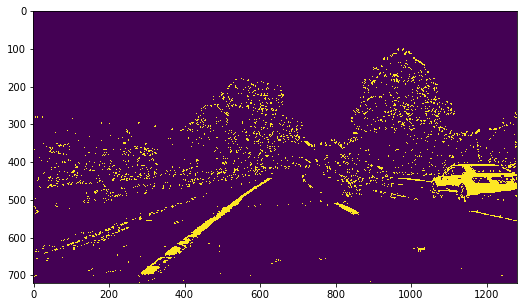

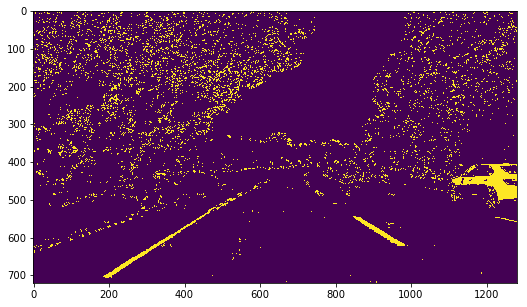

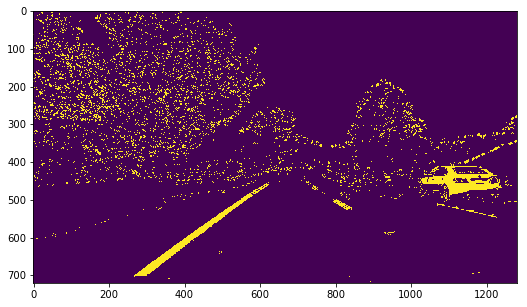

In [23]:
for img in test_imgs:
    combined_binary = combined_thresh(img)
    plt.figure(figsize=LARGE_FIGSIZE)
    plt.imshow(combined_binary)

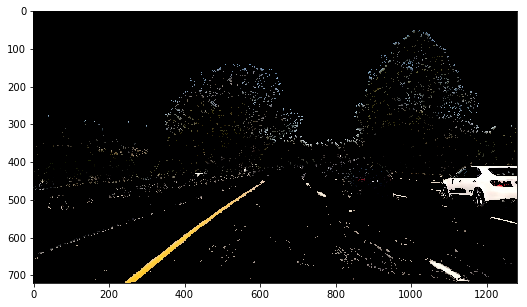

In [24]:
# Show the extract lane
plt.figure(figsize=LARGE_FIGSIZE)
plt.imshow(apply_combined_thresh(example_img))

### Test Combined Thresholding

In [25]:
thresh_output = './thresh.mp4'
#clip = VideoFileClip(PROJECT_VIDEO_PATH)
#thresh_clip = clip.fl_image(apply_combined_thresh)
#%time thresh_clip.write_videofile(thresh_output, audio=False)

In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(thresh_output))

## Perspective Transform

In [27]:
# Get source points from image with straight line
straight_line_imgs = []
for img_f in glob.glob(os.path.join(TEST_IMGS_PATH, "straight_lines*.jpg")):
    img = mpimg.imread(img_f)
    img = cv2.resize(img, CAM_IMG_SIZE)
    straight_line_imgs.append(undistort(img))

In [28]:
src = np.float32(
    [[(CAM_IMG_SIZE[0] / 2) - 60, CAM_IMG_SIZE[1] / 2 + 100],
    [((CAM_IMG_SIZE[0] / 6)) - 20, CAM_IMG_SIZE[1]],
    [(CAM_IMG_SIZE[0] * 5 / 6) + 60, CAM_IMG_SIZE[1]],
    [(CAM_IMG_SIZE[0] / 2 + 65), CAM_IMG_SIZE[1] / 2 + 100]])

# Get dst points by setting a fixed offset
offset_r =  1/4
dst = np.float32(
    [[(CAM_IMG_SIZE[0] * offset_r), 0],
    [(CAM_IMG_SIZE[0] * offset_r), CAM_IMG_SIZE[1]],
    [(CAM_IMG_SIZE[0] * (1 - offset_r)), CAM_IMG_SIZE[1]],
    [(CAM_IMG_SIZE[0] * (1 - offset_r)), 0]])

# Top down perspective Matrix
M = cv2.getPerspectiveTransform(src, dst)
# Reverse top down perspective Matrix
R_M = cv2.getPerspectiveTransform(dst, src)

class Wraper():
    def __init__(self, img_size, M, R_M):
        self.img_size = img_size
        self.M = M
        self.R_M = M
        
    def wrap(self, img):
        if img.shape[1] != self.img_size[0] or img.shape[0] != self.img_size[1]:
            raise ValueError("Image size {} is not the same size as: {}".format((img.shape[1], img.shape[0]), self.img_size))
        
        warped = cv2.warpPerspective(img, M, self.img_size, flags=cv2.INTER_LINEAR)  # keep same size as input image
        return warped
        
    def unwrap(self, img):
        if img.shape[1] != self.img_size[0] or img.shape[0] != self.img_size[1]:
            raise ValueError("Image size {} is not the same size as: {}".format((img.shape[1], img.shape[0]), self.img_size))
        
        img_size = (img.shape[1], img.shape[0])
        unwarped = cv2.warpPerspective(img, R_M, self.img_size, flags=cv2.INTER_LINEAR)  # keep same size as input image
        return unwarped
    
top_down_wraper = Wraper(CAM_IMG_SIZE, M, R_M)

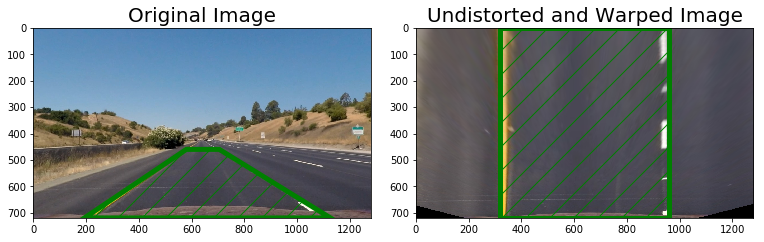

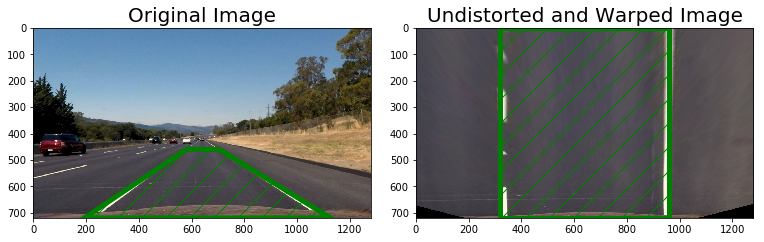

In [29]:
# Get a top-down view of the straight line images
for ix, img in enumerate(straight_line_imgs):
    top_down = top_down_wraper.wrap(img)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=LARGE_FIGSIZE)
    f.tight_layout()
    ax1.imshow(img)
    ax1.add_patch(Polygon(src, closed=True, fill=False, color='g', lw=5, hatch='/'))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(top_down)
    ax2.add_patch(Polygon(dst, closed=True, fill=False, color='g', lw=5, hatch='/'))
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig(os.path.join(OUTPUT_IMGS_PATH, 'top-down_{}.png'.format(ix)), transparent=True)

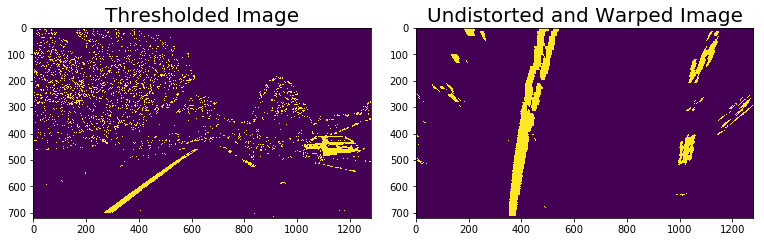

In [30]:
# Get a top down view of the thresholded example image
top_down = top_down_wraper.wrap(combined_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=LARGE_FIGSIZE)
f.tight_layout()
ax1.imshow(combined_binary)
ax1.set_title('Thresholded Image', fontsize=20)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Sliding Window Search

In [31]:
def window_mask(img_ref, width, height, center, level):
    """
    This function creates a mask of a window at given level.
    """
    mask = np.zeros_like(img_ref)
    mask[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,center-width//2):min(center+width//2,img_ref.shape[1])] = 1
    return mask

def find_window_centroids(img, window_width, window_height, margin, pre_l_center=None, pre_r_center=None):
    """
    This function applys Sliding Window to search for centroid positions of lane lines at each level
    """
    default_margin = margin
    l_margin = margin
    r_margin = margin
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    if pre_l_center is None:
        l_sum = np.sum(img[3*img.shape[0]//4:,:img.shape[1]//2], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width//2
    else:
        l_center = pre_l_center
    if pre_r_center is None:
        r_sum = np.sum(img[3*img.shape[0]//4:,img.shape[1]//2:], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width//2+img.shape[1]//2
    else:
        r_center = pre_l_center
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1, img.shape[0]//window_height):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(img[img.shape[0]-(level+1)*window_height:img.shape[0]-level*window_height,:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width//2
        l_min_index = max(l_center+offset-l_margin,0)
        l_max_index = min(l_center+offset+l_margin,img.shape[1])
        l_conv_index = np.argmax(conv_signal[l_min_index:l_max_index])
        if l_conv_index != 0:
            l_center = l_conv_index+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = max(r_center+offset-r_margin,0)
        r_max_index = min(r_center+offset+r_margin,img.shape[1])
        r_conv_index = np.argmax(conv_signal[r_min_index:r_max_index])
        if r_conv_index != 0:
            r_center = r_conv_index+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

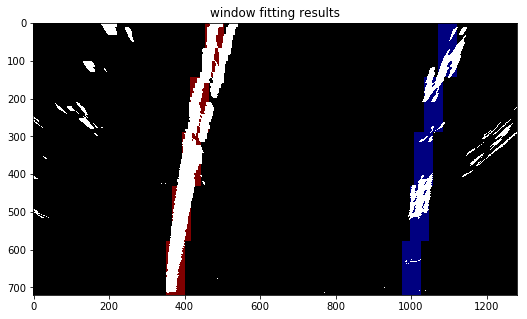

In [32]:
# window settings
window_width = 50
window_height = 720 // 5 # Break image into 9 vertical layers since image height is 720
margin = 40 # How much to slide left and right for searching
window_centroids = find_window_centroids(top_down, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(top_down)
    r_points = np.zeros_like(top_down)

    # Go through each level and draw the windows
    for level, (l_center, r_center) in enumerate(window_centroids):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(top_down,window_width,window_height,l_center,level)
        r_mask = window_mask(top_down,window_width,window_height,r_center,level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | (l_mask == 1) ] = 255
        r_points[(r_points == 255) | (r_mask == 1) ] = 255

    # Draw the results
    #template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    # create a zero color channel
    zero_channel = np.zeros_like(top_down)
    # make left points red and right points blue
    template = np.array(cv2.merge((l_points,zero_channel,r_points)),np.uint8)
    # making the original road pixels 3 color channels
    warpage = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8) * 255
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((top_down,top_down,top_down)),np.uint8)

# Display the final results
plt.figure(figsize=LARGE_FIGSIZE)
plt.imshow(output)
plt.title('window fitting results')

In [33]:
def fix_line(window_centroids, img_size, window_height):
    """
    This function fits a second order polynomial to each found centroids.
    """
    centroid_y = range(img_size[0]-window_height//2, 0, -window_height)
    left_fit = np.polyfit(centroid_y, [c[0] for c in window_centroids], 2)
    right_fit = np.polyfit(centroid_y, [c[1] for c in window_centroids], 2)
    return left_fit, right_fit

def genereate_plot_pts(ploty, left_fit, right_fit):
    """
    This function generates x and y values for plotting.
    """
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx

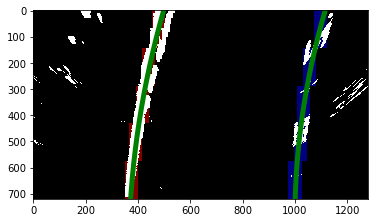

In [34]:
left_fit, right_fit = fix_line(window_centroids, top_down.shape, window_height)
ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0])
left_fitx, right_fitx = genereate_plot_pts(ploty, left_fit, right_fit)

plt.imshow(output)
plt.plot(left_fitx, ploty, color='g', lw=5)
plt.plot(right_fitx, ploty, color='g', lw=5)
plt.savefig(os.path.join(OUTPUT_IMGS_PATH, 'fit_lines.png'), transparent=True)

## Measuring Curvature

In [35]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def generate_curvature(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

In [36]:
left_curverad, right_curverad = generate_curvature(ploty, left_fitx, right_fitx)
print('left curve rad: {:8.2f} m'.format(left_curverad), 'right curve rad: {:8.2f} m'.format(right_curverad))

left curve rad:  1083.65 m right curve rad:   899.56 m


## Measuring Car Position

In [37]:
def generate_pos_shift(img_size, left_fitx, right_fitx):
    return ((right_fitx[-1]+left_fitx[-1]-img_size[0])//2) * xm_per_pix

In [38]:
pos_shift = generate_pos_shift(CAM_IMG_SIZE, left_fitx, right_fitx)
print('Vehicle is {:2.2f} m {} of center'.format(abs(pos_shift), 'left' if pos_shift > 0 else 'right'))

Vehicle is 0.24 m left of center


## Integrating Detected Lane and Measurements on Image

In [39]:
def produce_output(img, top_down, ploty, left_fitx, right_fitx, left_curverad, right_curverad, pos_shift):
    """
    This function produces a output image which contains detected lines and measurements.
    """
    zero_mask = np.zeros_like(top_down).astype(np.uint8)
    lane_mask = np.dstack((zero_mask, zero_mask, zero_mask))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(lane_mask, np.int_([pts]), (0,255, 0))

    # unwarp the lane mask from top view to normal
    lane_mask = top_down_wraper.unwrap(lane_mask)
    # plot back to example image
    output = cv2.addWeighted(img, 1, lane_mask, 0.3, 0.0) # overlay the orignal road image with window results

    # put measurements on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output, 'left curve rad: {:8.2f} m'.format(left_curverad), (100, 100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(output, 'right curve rad: {:8.2f} m'.format(right_curverad), (100, 150), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(output, 'Vehicle is {:2.2f} m {} of center'.format(abs(pos_shift), 'left' if pos_shift > 0 else 'right'), 
                (100, 200), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return output

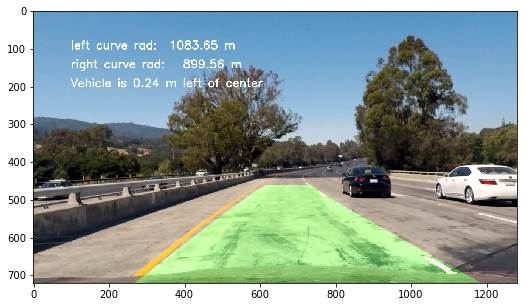

In [40]:
output = produce_output(example_img, top_down, ploty, left_fitx, right_fitx, left_curverad, right_curverad, pos_shift)
cv2.imwrite(os.path.join(OUTPUT_IMGS_PATH, "result.png"), cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.figure(figsize=LARGE_FIGSIZE)
plt.imshow(output)

In [51]:
enable_log = False
window_width = 50
window_height = 720 // 5 # Break image into 9 vertical layers since image height is 720
margin = 80 # How much to slide left and right for searching
smooth_ratio = 0.9

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = None
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        #self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        #self.line_base_pos = None 

def adv_line_detect(img):
    """
    This function detects lines within the image. It is used for processing each frame of a video.
    """
    undistorted_img = undistort(img)
    binary = combined_thresh(undistorted_img)
    top_down = top_down_wraper.wrap(binary)
    
    if left_line.detected:
        pre_l_center = int(left_line.bestx[-1])
    else:
        pre_l_center = None
    if right_line.detected:
        pre_r_center = int(right_line.bestx[-1])
    else:
        pre_r_center = None

    window_centroids = find_window_centroids(top_down, window_width, window_height, margin)
    
    if len(window_centroids) <= 0:
        left_line.detected = False
        right_line.detected = False
    else:
        if enable_log:
            print("line detected")
        left_fit, right_fit = fix_line(window_centroids, top_down.shape, window_height)
        
        if left_line.best_fit is None:
            left_line.best_fit = left_fit
        else:
            #left_line.best_fit = smooth_ratio*left_line.best_fit + (1-smooth_ratio)*left_fit
            left_line.best_fit = left_fit
        if right_line.best_fit is None:
            right_line.best_fit = right_fit
        else:
            #right_line.best_fit = smooth_ratio*right_line.best_fit + (1-smooth_ratio)*right_fit
            right_line.best_fit = right_fit
        
        ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0])
        left_fitx, right_fitx = genereate_plot_pts(ploty, left_line.best_fit, right_line.best_fit)     
        
        if left_line.recent_xfitted is None:
            left_line.recent_xfitted = left_fitx
        if right_line.recent_xfitted is None:
            right_line.recent_xfitted = right_fitx
        
        # shift too much
        if abs(np.mean(left_fitx) - np.mean(left_line.recent_xfitted)) > 10:
            left_line.detected = False
        if abs(np.mean(right_fitx) - np.mean(right_line.recent_xfitted)) > 10:
            right_line.detected = False
        
        left_curverad, right_curverad = generate_curvature(ploty, left_fitx, right_fitx)
        
        if abs(left_curverad - right_curverad) > 10000:
            if enable_log:
                print("wrong dectection")
            left_line.detected |= abs(left_curverad - left_line.radius_of_curvature) < 5000
            right_line.detected |= abs(right_curverad - right_line.radius_of_curvature) < 5000
        else:
            left_line.detected |= True
            right_line.detected |= True
        
    if left_line.detected:
        left_line.recent_xfitted = left_fitx
        if enable_log:
            print("left line detected")
        if left_line.bestx is None:
            left_line.bestx = left_line.recent_xfitted
        else:
            left_line.bestx = smooth_ratio*left_line.bestx + (1-smooth_ratio)*left_line.recent_xfitted
        left_line.radius_of_curvature = left_curverad
    if right_line.detected:
        right_line.recent_xfitted = right_fitx
        if enable_log:
            print("right line detected")
        if right_line.bestx is None:
            right_line.bestx = right_line.recent_xfitted
        else:
            right_line.bestx = smooth_ratio*right_line.bestx + (1-smooth_ratio)*right_line.recent_xfitted
        right_line.radius_of_curvature = right_curverad
    
    pos_shift = generate_pos_shift(CAM_IMG_SIZE, left_line.bestx, right_line.bestx)
    output = produce_output(img, top_down, ploty, 
                            left_line.bestx, right_line.bestx, 
                            left_line.radius_of_curvature, right_line.radius_of_curvature, 
                            pos_shift)
    return output

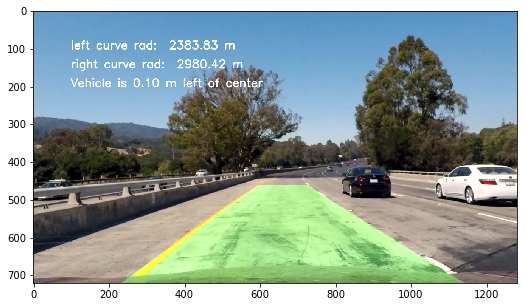

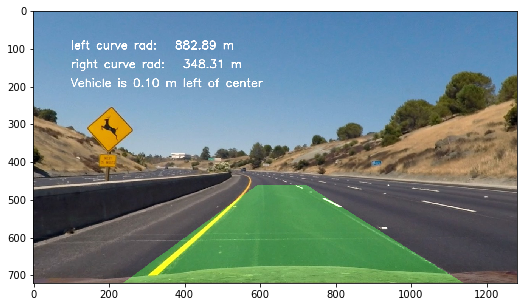

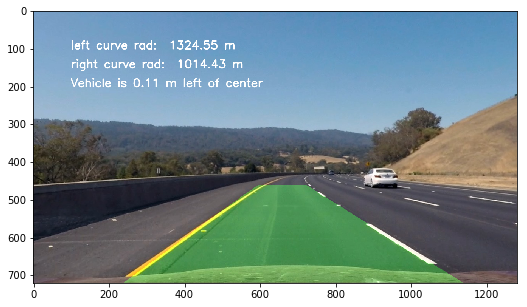

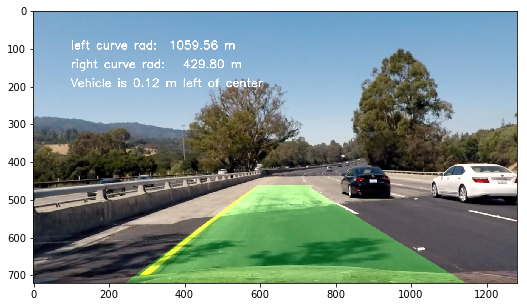

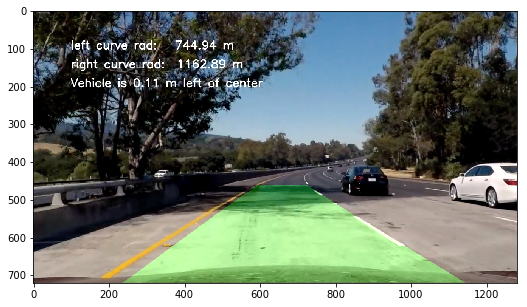

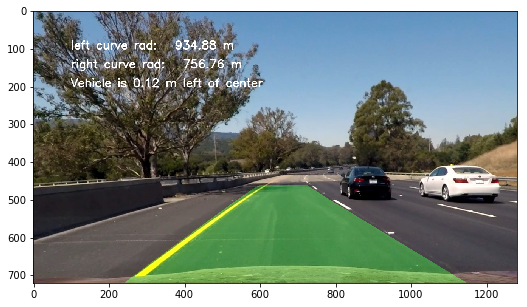

In [52]:
left_line = Line()
right_line = Line()
for img in test_imgs:
    plt.figure(figsize=LARGE_FIGSIZE)
    plt.imshow(adv_line_detect(img))

In [53]:
left_line = Line()
right_line = Line()
result_output = './result.mp4'
clip = VideoFileClip(PROJECT_VIDEO_PATH)
result_clip = clip.fl_image(adv_line_detect)
%time result_clip.write_videofile(result_output, audio=False)

[MoviePy] >>>> Building video ./result.mp4
[MoviePy] Writing video ./result.mp4


100%|██████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:17<00:00,  6.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result.mp4 

Wall time: 3min 18s


In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(result_output))

In [45]:
left_line = Line()
right_line = Line()
challenge_output = './challenge_result.mp4'
clip = VideoFileClip('./challenge_video.mp4')
challenge_clip = clip.fl_image(adv_line_detect)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ./challenge_result.mp4
[MoviePy] Writing video ./challenge_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████| 485/485 [01:16<00:00,  6.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_result.mp4 

Wall time: 1min 16s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))